Some packages we'll need below - make sure you have them installed! 

If you use `conda`:

    conda install numpy matplotlib scikit-learn scipy

If you use `pip`:

    pip install numpy matplotlib scikit-learn scipy

In [124]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import norm
from scipy.special import logsumexp
from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity

# Density estimation

## 1) Kernel density estimation

Most problems in astronomy (and science?) involve or require estimating an underlying density distribution given some (often noisy) discrete observations. More generally, essentially all statistical inference problems boil down to estimating the probability density over some parameters, or computing integrals over probability densities. When our models are _parametric_, we use algorithms like MCMC to generate samples from density distributions over the parameters in our model. But sometimes we (1) don't have a model, (2) have a parametric but purely numerical model, or (3) want to quickly visualize the density given discrete samples. In these cases we can instead do _non-parametric_ density estimation.

As astronomers, non-parametric density estimation is amongst the first data analysis / visualization skills we learn: We all know and love the histogram!

#### How to astronomy:

1. Discover object / phenomenon
2. Find / create a sample
3. Make histogram
4. ??
5. Profit

The histogram is a great tool for visualization: it is fast, and a standard (people know how to read it). But there are some important caveats that other methods improve on. In particular, the conclusions we draw from looking at a histogram often depend strongly on the choice of bins, both the locations of the bins and the widths of the bins.

For example, let's generate histograms of some 1D point data - in the plots to follow, all of the histograms are made with the same points (variable `x` below), but with different choices for the bin widths and the bin positions:

In [190]:
x1 = np.random.normal(0.25, 0.1, size=200)
x2 = np.random.normal(1., 0.5, size=1000)
x = np.concatenate((x1, x2))
np.random.shuffle(x) # we'll rely on this later!

def true_x_density(x):
    return ((1/6)*norm.pdf(x, loc=0.25, scale=0.1) + 
            (5/6)*norm.pdf(x, loc=1., scale=0.5))

Left-to-right we shift all of the bins at a fixed number of bins, top-to-bottom we change the number of bins:

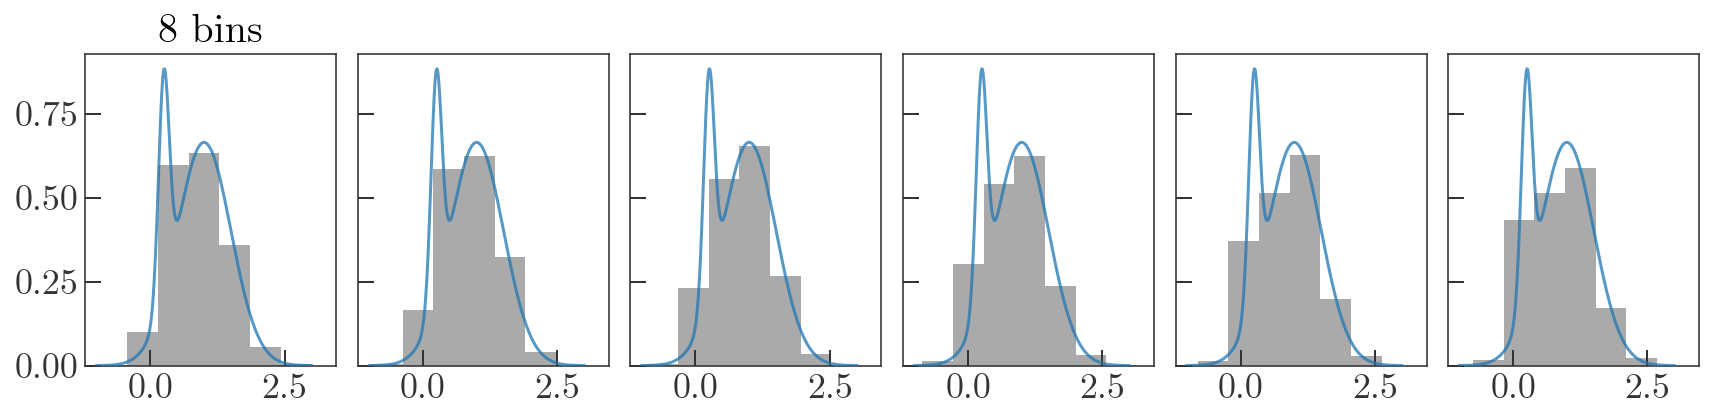

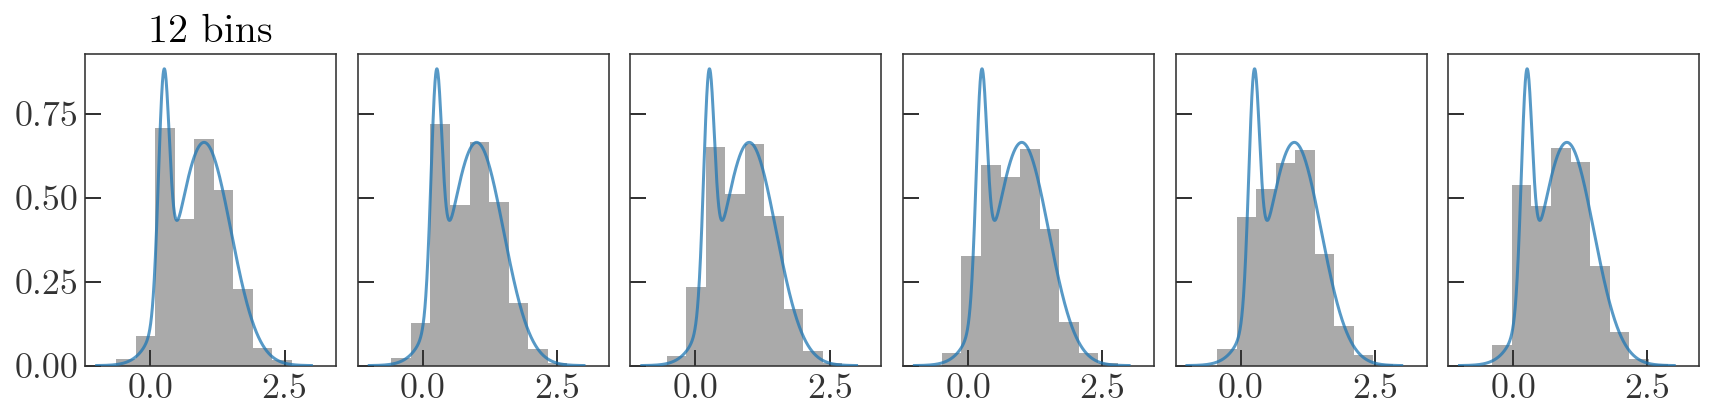

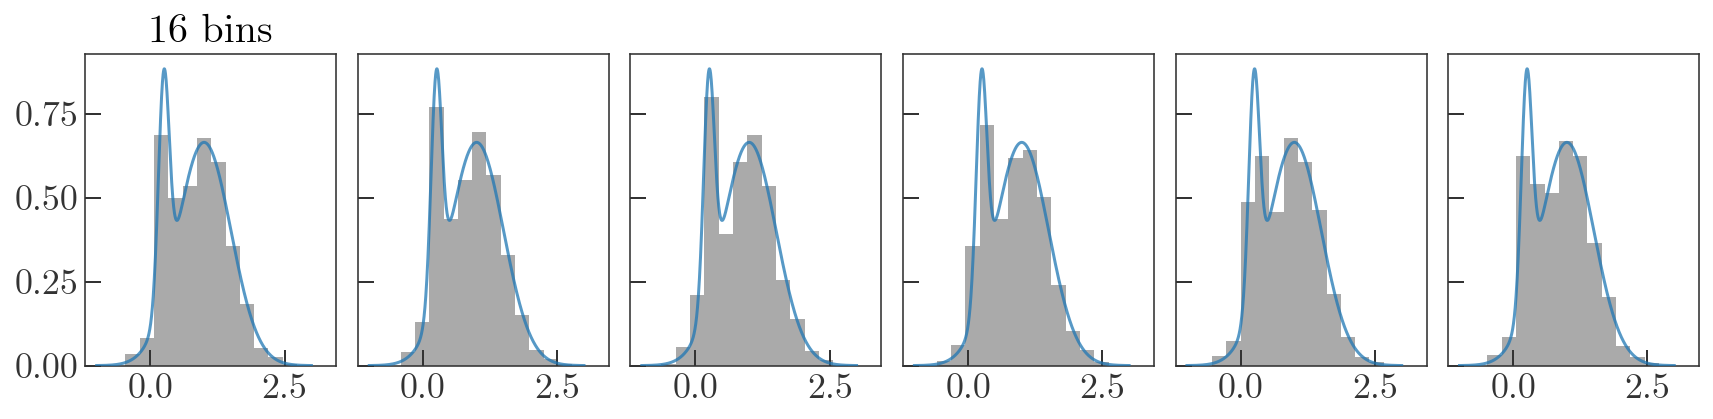

In [191]:
for n_bins in [8, 12, 16]:
    bins = np.linspace(-1, 3, n_bins)

    fig, axes = plt.subplots(1, 6, figsize=(12, 3), 
                             sharex=True, sharey=True)
    
    x_grid = np.linspace(-1, 3, 1000)
    for i, ax in enumerate(axes.flat):
        ax.hist(x, bins=bins + i/20, normed=True, color='#aaaaaa')
        ax.plot(x_grid, true_x_density(x_grid), marker='', 
                alpha=0.75, zorder=10, color='tab:blue')
    
    axes[0].set_title('{0} bins'.format(n_bins), fontsize=20)
    fig.tight_layout()

Is the above distribution unimodal or bimodal?

In a histogram, the bin locations and widths are fixed, and the density at the location of each bin is estimated by "moving" data points into each bin and counting. How else could we estimate the density at a location using bins? We could instead fix the bin widths and the data point locations, and move the bin locations to be overlapping and centered on each data point. 

In [192]:
def point_centered_histogram(x, bin_width, data):
    data = np.array(data)
    x = np.array(x)
    y = (data[None] - x[:, None]) / (bin_width/2.)
    return np.sum(np.abs(y) < 1., axis=1) / (len(data) * bin_width)

Let's try this on some trivial data to start before applying it to the point data from above:

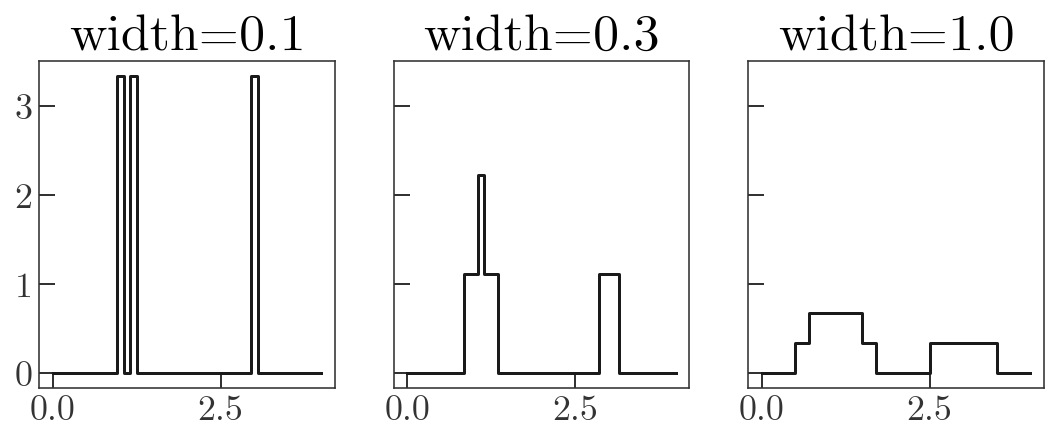

In [193]:
x_grid = np.linspace(0, 4, 512)
data = [1., 1.2, 3.]
bin_widths = [0.1, 0.3, 1.]

fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)

for i, ax in enumerate(axes.flat):
    ax.plot(x_grid, point_centered_histogram(x_grid, bin_widths[i], data), 
            marker='', drawstyle='steps-mid')
    
    ax.set_title('width={0:.1f}'.format(bin_widths[i]))

In the panel on the left, when the bin width is small, we see how our "bins" are now centered on the data themselves. As we increase the bin width (left-to-right), we see that our bins are allowed to overlap. Here we have removed the need to specify bin locations, but we still need to specify the bin width. What we have implemented here is a _kernel density estimation_ of the underlying density, where our kernel is a top-hat function! Let's see how this does with our previous data set:

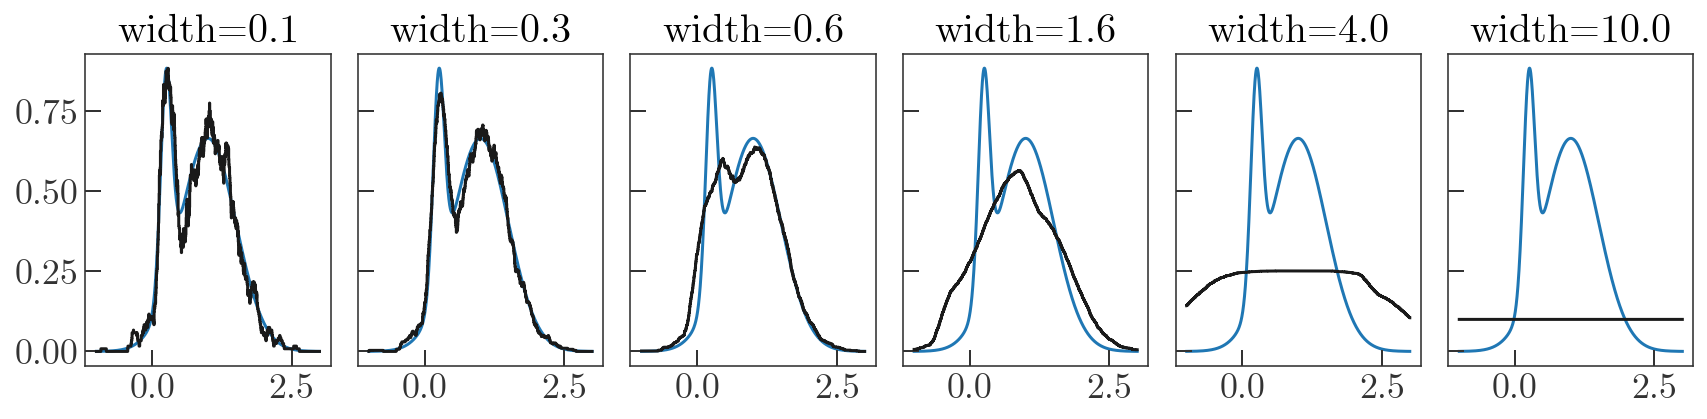

In [194]:
fig, axes = plt.subplots(1, 6, figsize=(12, 3), 
                         sharex=True, sharey=True)

bin_widths = np.logspace(-1, 1, len(axes))

x_grid = np.linspace(-1, 3, 1024)
for i, ax in enumerate(axes.flat):
    ax.plot(x_grid, point_centered_histogram(x_grid, bin_widths[i], x), 
            marker='', drawstyle='steps-mid')
    
    ax.plot(x_grid, true_x_density(x_grid), 
            zorder=-10, marker='', color='tab:blue')

    ax.set_title('width={0:.1f}'.format(bin_widths[i]), fontsize=20)
fig.tight_layout()

When the bin size is small, the estimated density is very noisy. As we increase the bin width---the half-width is often called the __bandwidth__---small-scale features get washed out (just like in a standard histogram). Somewhere around width=0.3–0.5, the density estimate looks pretty good (true density is plotted in blue)! 

But here's where kernel density estimation gets interesting: The top-hat is just one choice for a kernel function - there are many more we can choose from! In the below, we're going to assume that we're working with 1D data (see other resources for the expressions for higher-dimensional cases). The key idea is the same as above: our density estimate at a given location, $\hat{f}(x)$, given some kernel function $K(z)$ and bandwidth $b$ is computed as

$$
    \hat{f}(x) = \frac{1}{N}\,\frac{1}{h} \, \sum_n^N K\left( \frac{\left|x - x_n\right|}{b} \right)
$$

where the $N$ data points are indexed as $x_n$.

Above, we used the __top-hat kernel__:

$$
    K(z) = \begin{cases}
        1,~{\rm if}~z \leq 1\\
        0,~{\rm else}
        \end{cases}
$$

Other popular choices are the __Gaussian kernel__:

$$
    K(z) = \frac{1}{\sqrt{2\pi}} \, \exp{\left(-\frac{z^2}{2}\right)}
$$

__Epanechnikov kernel__:

$$
    K(z) = \frac{3}{4} \, (1 - z^2)
$$

All of the above kernels are implemented in `scikit-learn`; let's now use `scikit-learn` to build KDE's of the above data using the different kernels, but the same bandwidth:

In [195]:
kde_tophat = KernelDensity(bandwidth=0.2, kernel='tophat')
kde_gauss = KernelDensity(bandwidth=0.2, kernel='gaussian')
kde_epan = KernelDensity(bandwidth=0.2, kernel='epanechnikov')
kdes = [kde_tophat, kde_gauss, kde_epan]

In [196]:
X = x.reshape(-1, 1)
for kde in kdes:
    kde.fit(X)

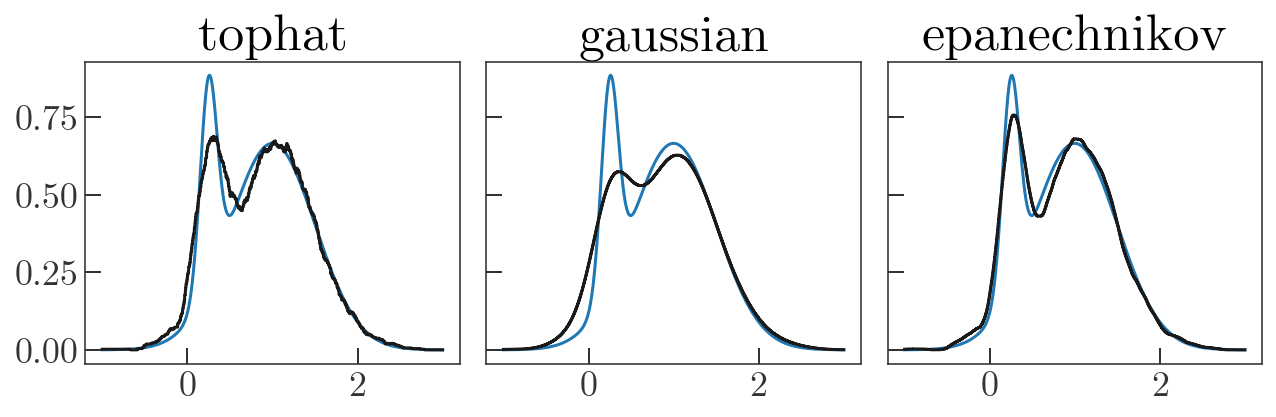

In [197]:
fig, axes = plt.subplots(1, 3, figsize=(9, 3), 
                         sharex=True, sharey=True)

x_grid = np.linspace(-1, 3, 1024)
for ax, kde in zip(axes.flat, kdes):
    ax.plot(x_grid, np.exp(kde.score_samples(x_grid.reshape(-1, 1))),
            marker='', drawstyle='steps-mid')
    
    ax.plot(x_grid, true_x_density(x_grid), 
            zorder=-10, marker='', color='tab:blue')
    
    ax.set_title(kde.kernel)
    
fig.tight_layout()

...gaussian not efficient - need to get bandwidth right

## Bandwidth selection

With a histogram, we have to specify the bin locations and bin widths. With kernel density estimation, we still have to set the scale length or bandwidth of the kernel. The bandwidth controls how smooth the resulting density estimate will be and therefore has a huge impact on our conclusions. So how do we choose this bandwidth? 

__cross-validation!__

In brief: we can hold out some data at random, build the density estimate, then compute the likelihood of the held-out data under the KDE. We can then optimize over the likelihood.

In a little more detail: cross-validation is ... need a cost / loss function ... here we can use the KDE-computed density (i.e. the likelihood) itself!

In [198]:
def cv_neg_ln_likelihood(p):
    ln_b = p[0]
    kde_gauss = KernelDensity(bandwidth=np.exp(ln_b), kernel='gaussian')
    kde_gauss.fit(train_x.reshape(-1, 1))
    return -np.sum(kde_gauss.score_samples(test_x.reshape(-1, 1)))

In [199]:
bs = []

for i in range(32):
    idx = np.random.choice(len(x), len(x), replace=False)
    test_x = x[idx[:x.size//8]]
    train_x = x[idx[x.size//8:]]

    res = minimize(cv_neg_ln_likelihood, x0=-1)
    bs.append(np.exp(res.x[0]))
best_b = np.mean(bs)
best_b

0.076247005270201784

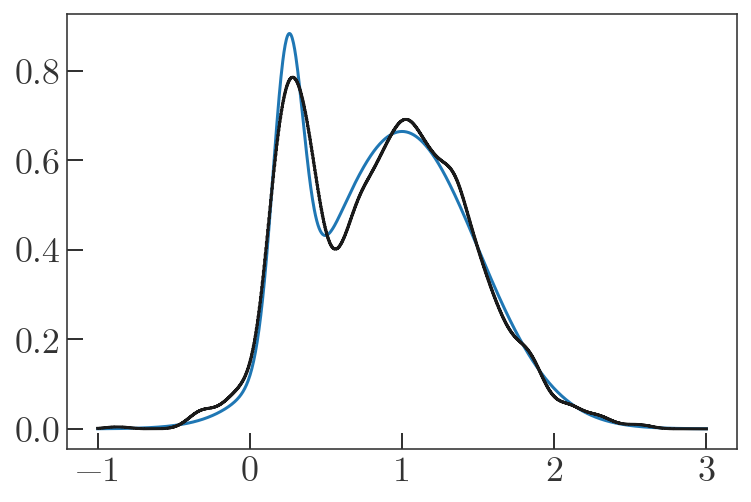

In [200]:
kde_gauss = KernelDensity(bandwidth=best_b, kernel='gaussian')
kde_gauss.fit(x.reshape(-1, 1))

plt.plot(x_grid, np.exp(kde_gauss.score_samples(x_grid.reshape(-1, 1))),
         marker='', drawstyle='steps-mid')
plt.plot(x_grid, true_x_density(x_grid), 
         zorder=-10, marker='', color='tab:blue')

In [201]:
from sklearn.model_selection import GridSearchCV

In [202]:
params = {'bandwidth': np.logspace(-3, 1, 128)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(x.reshape(-1, 1))

GridSearchCV(cv=None, error_score='raise',
       estimator=KernelDensity(algorithm='auto', atol=0, bandwidth=1.0, breadth_first=True,
       kernel='gaussian', leaf_size=40, metric='euclidean',
       metric_params=None, rtol=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'bandwidth': array([  1.00000e-03,   1.07522e-03, ...,   9.30045e+00,   1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

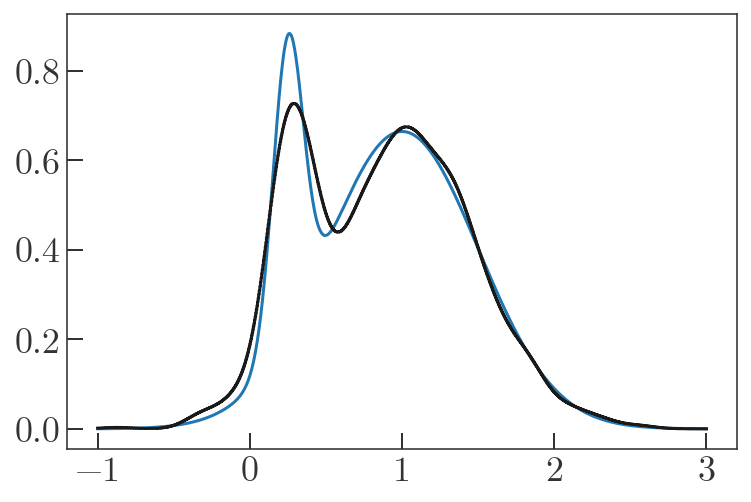

In [203]:
kde_gauss = KernelDensity(bandwidth=grid.best_params_['bandwidth'], 
                          kernel='gaussian')
kde_gauss.fit(x.reshape(-1, 1))

plt.plot(x_grid, np.exp(kde_gauss.score_samples(x_grid.reshape(-1, 1))),
         marker='', drawstyle='steps-mid')
plt.plot(x_grid, true_x_density(x_grid), 
         zorder=-10, marker='', color='tab:blue')

## Example / toy problem: 

We've measured very precise distances to a sample of galaxies. Some of those galaxies lie in a cluster, others just belong to the field population...

...but need to deconvolve

...but what about selection effects

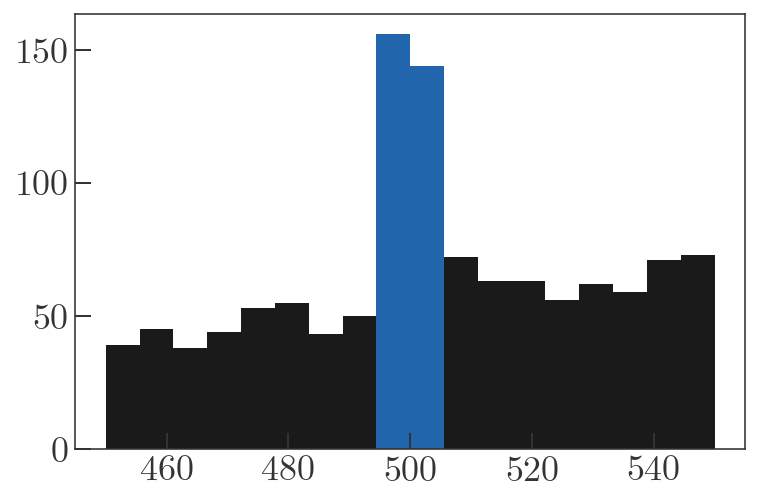

In [221]:
n_cluster = 300
n_field = 1000

dist_cluster = np.random.normal(500., 1., n_cluster)
dist_field = np.cbrt(np.random.uniform(450**3, 550**3, n_field))

dist_bins = np.linspace(450, 550, 19)
plt.hist(dist_field, bins=dist_bins);
plt.hist(dist_cluster, bins=dist_bins);

In [222]:
new_dist = 500.6242

In [229]:
params = {'bandwidth': np.logspace(-3, 1, 128)}

kde_cluster = KernelDensity()
grid_c = GridSearchCV(KernelDensity(), params)
grid_c.fit(dist_cluster.reshape(-1, 1))

kde_cluster = KernelDensity(bandwidth=grid_c.best_params_['bandwidth'])
kde_cluster.fit(dist_cluster.reshape(-1, 1))

KernelDensity(algorithm='auto', atol=0, bandwidth=0.38254027466328744,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)

In [230]:
kde_field = KernelDensity()
grid_f = GridSearchCV(KernelDensity(), params)
grid_f.fit(dist_field.reshape(-1, 1))

kde_field = KernelDensity(bandwidth=grid_f.best_params_['bandwidth'])
kde_field.fit(dist_field.reshape(-1, 1))

KernelDensity(algorithm='auto', atol=0, bandwidth=1.411257617811452,
       breadth_first=True, kernel='gaussian', leaf_size=40,
       metric='euclidean', metric_params=None, rtol=0)

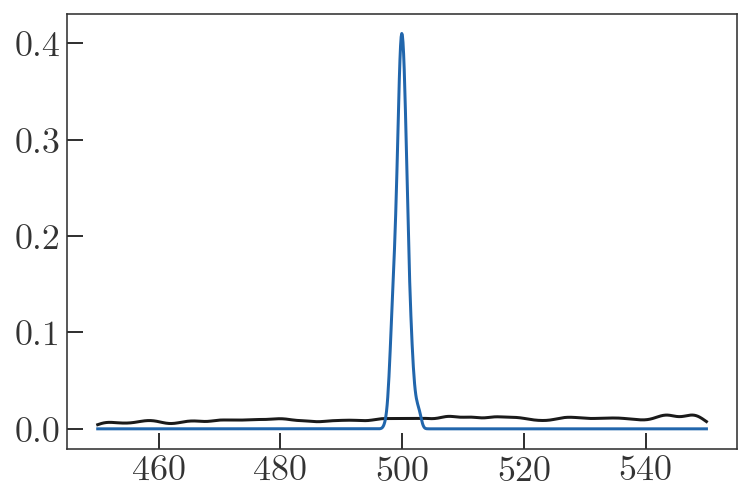

In [232]:
dist_grid = np.linspace(450, 550, 1000)

plt.plot(dist_grid, np.exp(kde_field.score_samples(dist_grid.reshape(-1, 1))), 
         marker='')

plt.plot(dist_grid, np.exp(kde_cluster.score_samples(dist_grid.reshape(-1, 1))), 
         marker='')

In [242]:
new_dist = 502
np.exp(np.log(n_cluster) - np.log(n_field) + kde_cluster.score(new_dist) - kde_field.score(new_dist))

1.4009702784786247

## Example from the literature

For stellar stream fitting: [Price-Whelan et al. 2016](https://ui.adsabs.harvard.edu/#abs/2016ApJ...824..104P/abstract)

In [270]:
import astropy.units as u
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics.mockstream import fardal_stream

In [271]:
w0 = gd.PhaseSpacePosition(pos=[15, 0, 0]*u.kpc,
                           vel=[0, 15, 170.] * u.km/u.s)

potential = gp.MilkyWayPotential()
H = gp.Hamiltonian(potential)

In [275]:
orbit = H.integrate_orbit(w0, dt=0.5, n_steps=6000)

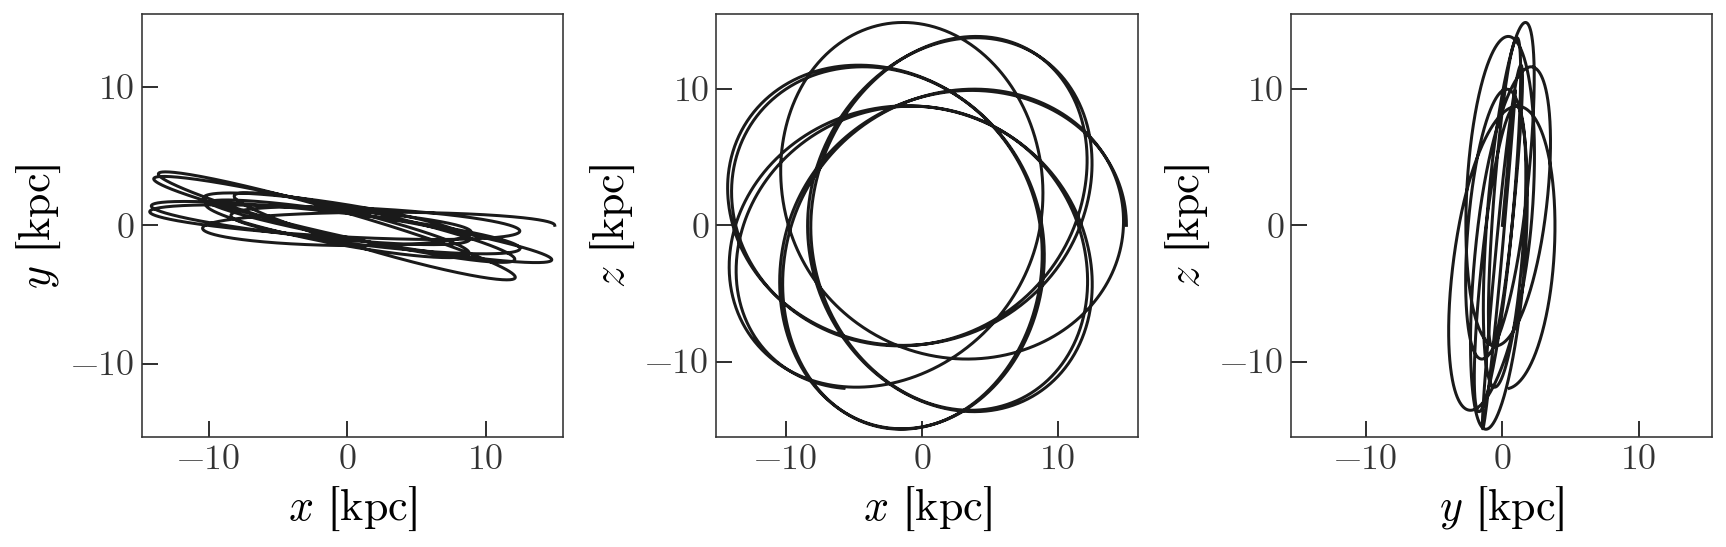

In [276]:
_ = orbit.plot()

In [279]:
stream = fardal_stream(H, orbit, 5E5*u.Msun, release_every=4)

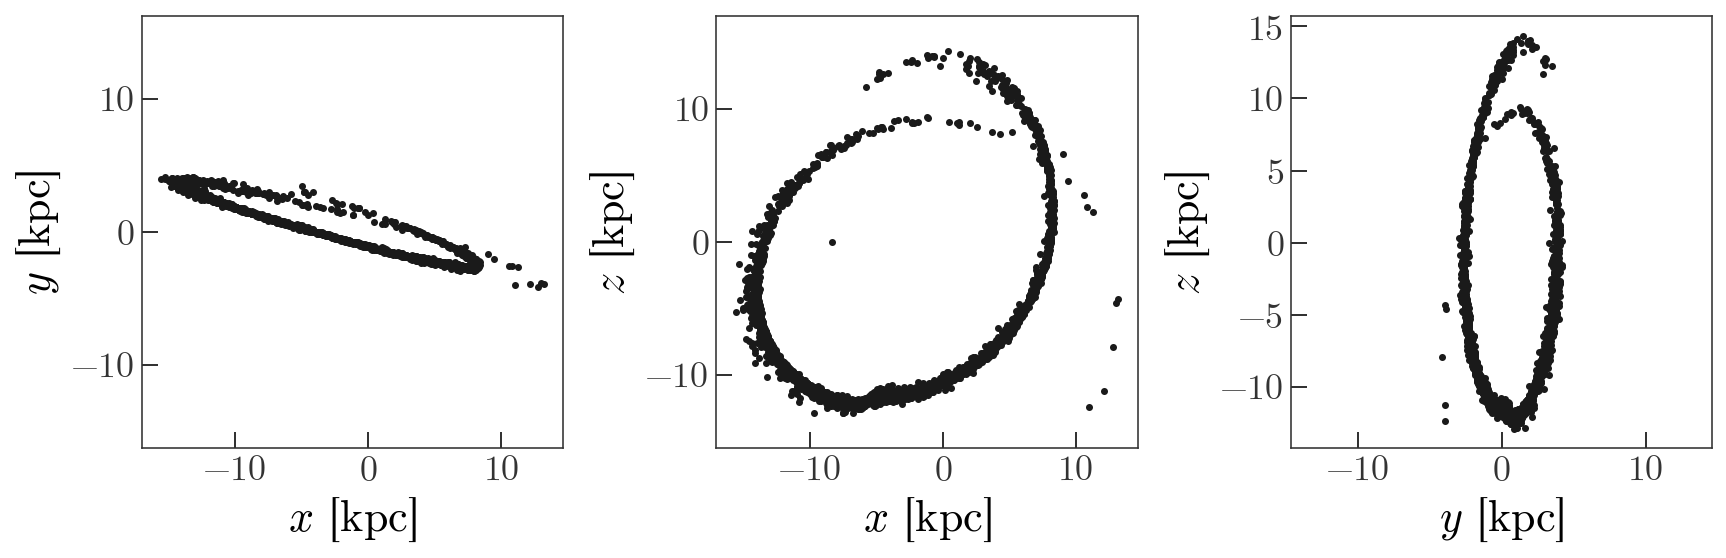

In [280]:
_ = stream.plot()

...motivate GMMs